
## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
import sklearn
from torch.utils.data.sampler import SubsetRandomSampler

import sys,os
sys.path.append(os.path.abspath("/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/"))
from imp import reload 
# Change in mymodule/'
import vib_utils
reload(vib_utils)
from vib_utils import *
import mist_utils
reload(mist_utils)
from mist_utils import *

import warnings
warnings.filterwarnings('ignore')

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu' # temporarily
# Fix random seeds for reproducibility
seed = 73
#torch.manual_seed(seed)
#np.random.seed(seed)a
import sys,os 
import matplotlib.pyplot as plt
import numpy as np
sys.path.append(os.path.abspath("/mnt/home/yjo10/ceph/myutils/"))
from plt_utils import generateAxesForMultiplePlots, remove_inner_axes
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import chi2_contingency
import optuna
# Dimension reduction and clustering libraries
import umap
#import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from plt_utils import generateAxesForMultiplePlots

In [2]:
def do_classification(mist):
    X,y     =mist.train_loader.dataset.tensors
    X_train, y_train = X[mist.train_indices].cpu().detach().numpy(), y[mist.train_indices].cpu().detach().numpy()
    y_train = y_train[:,2:]
    Z_train = mist.get_latent_variable(X=X_train)
    
    clf = RandomForestClassifier(n_estimators=50,max_depth=20, random_state=0)
    clf.fit(Z_train, y_train)
    X_test, y_test = mist.test_dataset.tensors
    Z_test = mist.get_latent_variable()
    y_test = y_test[:,2:].cpu().detach().numpy()
    y_pred = clf.predict(Z_test)
    auc    = sklearn.metrics.roc_auc_score(y_test, y_pred)
    fi     = clf.feature_importances_
    
    return clf, auc, fi, (Z_test, y_test, y_pred), (Z_train, y_train)

In [3]:
sim  = ['TNG', 'SIMBA']; field = 'HI'
study_name = "TNG_SIMBA_HI_wph_zero"
storage    = f"sqlite:////mnt/home/yjo10/ceph/CAMELS/MIEST/information_bottleneck/database/{study_name}.db"
mist = MIST(sim=sim, field=field, batch_size=1000, 
            data_type = 'wph',
            normalization=True,
            monopole = True,
            projection=False,
            average=False,
            device=device,
            L=4, dn=2, proc_imag=np.absolute)
mist.load_optuna_models(storage=storage,study_name=study_name, which_machine="vib+cls",num_trial=None)

In [4]:
X_ast, y_ast = mist.load_data(external=True, external_sims='ASTRID')

In [5]:
clf, auc, fi, testset, trainset = do_classification(mist)
Z_test, y_test, y_pred = testset

In [6]:
print(auc)

0.961515714111016


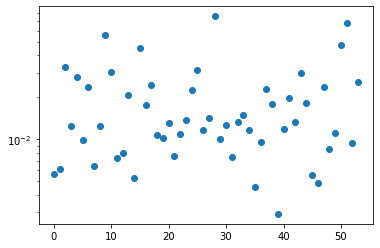

In [7]:
fi = clf.feature_importances_
plt.scatter(range(len(fi)), fi)
plt.yscale("log")
index = np.where(fi>1e-2)[0]
not_index = np.where(fi<=1e-4)[0]

In [8]:
Z_train, y_train = trainset

In [ ]:
Z_train, y_train = trainset
clf = RandomForestClassifier(n_estimators=50,max_depth=20, random_state=0)
clf.fit(Z_train[:, not_index], y_train)

In [ ]:
y_pred = clf.predict(Z_test[:,not_index])
auc    = sklearn.metrics.roc_auc_score(y_test, y_pred)

In [ ]:
auc

#### include ASTRID

In [9]:
ast_indices = np.random.randint(low=0, high=X_ast.shape[0], size=Z_test.shape[0]//2)
X_ast_test, y_ast_test = X_ast[ast_indices,:], y_ast[ast_indices,:]
Z_ast_test = mist.get_latent_variable(X_ast_test)

In [10]:
Z_test_all = np.r_[Z_test,Z_ast_test]
Z_test_all.shape
y_test_all = np.zeros((Z_test_all.shape[0], 3))
y_test_all[:Z_test.shape[0],:2] = y_test
y_test_all[Z_test.shape[0]:,2]  = 1 

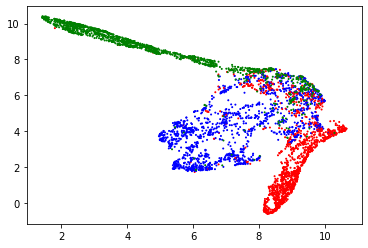

In [11]:
label                 = y_test_all
clabel                = np.empty((label.shape[0]),dtype=str)
clabel[label[:,0]==1] = 'b'
clabel[label[:,1]==1] = 'r'
clabel[label[:,2]==1] = 'g'
standard_embedding    = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test_all[:,index])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

In [18]:
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test_all[:,not_index])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

ValueError: Found array with 0 feature(s) (shape=(4500, 0)) while a minimum of 1 is required.

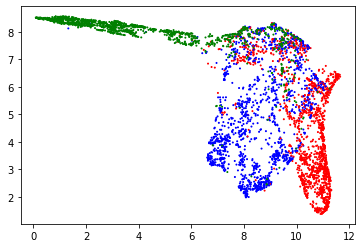

In [12]:
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test_all)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

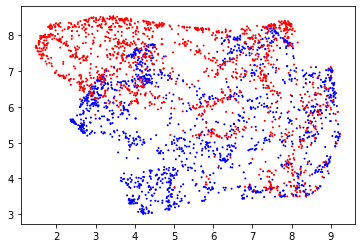

In [13]:
label = y_test
clabel = ["b" if l == 1 else "r" for l in label[:,0]]
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test[:,index])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

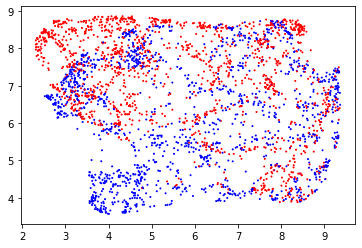

In [14]:
label = y_test
clabel = ["b" if l == 1 else "r" for l in label[:,0]]
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

In [81]:
sim  = ['TNG', 'SIMBA']; field = 'HI'
study_name = "TNG_SIMBA_HI_wph_high3_adamw"
storage    = f"sqlite:////mnt/home/yjo10/ceph/CAMELS/MIEST/information_bottleneck/database/{study_name}.db"
mist = MIST(sim=sim, field=field, batch_size=1000, 
            data_type = 'wph',
            normalization=True,
            monopole = True,
            projection=False,
            average=False,
            device=device,
            L=4, dn=2, proc_imag=np.absolute)
mist.load_optuna_models(storage=storage,study_name=study_name, which_machine="vib+cls",num_trial=387)

In [82]:
X_ast, y_ast = mist.load_data(external=True, external_sims='ASTRID')

In [83]:
clf, auc, fi, testset, trainset = do_classification(mist)
Z_test, y_test, y_pred = testset

In [84]:
print(auc)

0.603539704950473


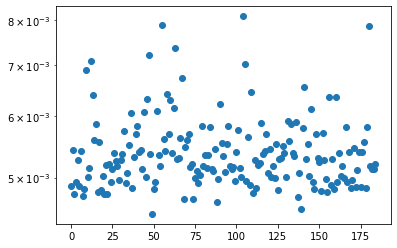

In [85]:
fi = clf.feature_importances_
plt.scatter(range(len(fi)), fi)
plt.yscale("log")
index = np.where(fi>1e-4)[0]
not_index = np.where(fi<=1e-4)[0]

In [86]:
Z_train, y_train = trainset

#### include ASTRID

In [87]:
ast_indices = np.random.randint(low=0, high=X_ast.shape[0], size=Z_test.shape[0]//2)
X_ast_test, y_ast_test = X_ast[ast_indices,:], y_ast[ast_indices,:]
Z_ast_test = mist.get_latent_variable(X_ast_test)

In [88]:
Z_test_all = np.r_[Z_test,Z_ast_test]
Z_test_all.shape
y_test_all = np.zeros((Z_test_all.shape[0], 3))
y_test_all[:Z_test.shape[0],:2] = y_test
y_test_all[Z_test.shape[0]:,2]  = 1 

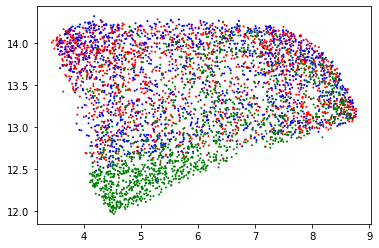

In [89]:
label                 = y_test_all
clabel                = np.empty((label.shape[0]),dtype=str)
clabel[label[:,0]==1] = 'b'
clabel[label[:,1]==1] = 'r'
clabel[label[:,2]==1] = 'g'
standard_embedding    = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test_all[:,index])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

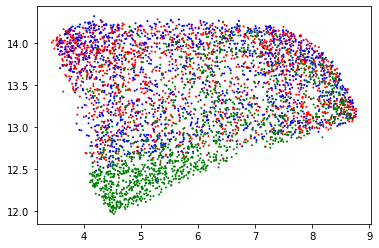

In [90]:
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test_all)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

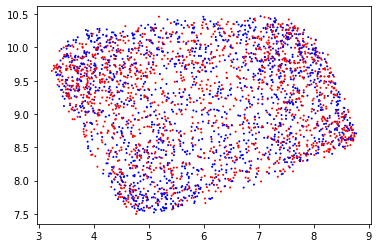

In [91]:
label = y_test
clabel = ["b" if l == 1 else "r" for l in label[:,0]]
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test[:,index])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

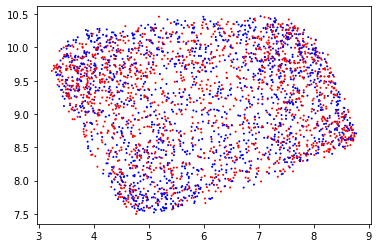

In [92]:
label = y_test
clabel = ["b" if l == 1 else "r" for l in label[:,0]]
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

In [93]:
sim  = ['TNG', 'SIMBA']; field = 'HI'
study_name = "TNG_SIMBA_HI_wph_high3_adamw"
storage    = f"sqlite:////mnt/home/yjo10/ceph/CAMELS/MIEST/information_bottleneck/database/{study_name}.db"
mist = MIST(sim=sim, field=field, batch_size=1000, 
            data_type = 'wph',
            normalization=True,
            monopole = True,
            projection=False,
            average=False,
            device=device,
            L=4, dn=2, proc_imag=np.absolute)
mist.load_optuna_models(storage=storage,study_name=study_name, which_machine="vib+cls",num_trial=95)

In [94]:
X_ast, y_ast = mist.load_data(external=True, external_sims='ASTRID')

In [95]:
clf, auc, fi, testset, trainset = do_classification(mist)
Z_test, y_test, y_pred = testset

In [96]:
print(auc)

0.5539304732576625


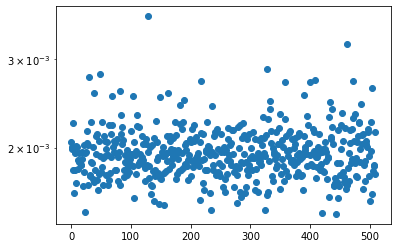

In [97]:
fi = clf.feature_importances_
plt.scatter(range(len(fi)), fi)
plt.yscale("log")
index = np.where(fi>1e-4)[0]
not_index = np.where(fi<=1e-4)[0]

In [98]:
Z_train, y_train = trainset

#### include ASTRID

In [99]:
ast_indices = np.random.randint(low=0, high=X_ast.shape[0], size=Z_test.shape[0]//2)
X_ast_test, y_ast_test = X_ast[ast_indices,:], y_ast[ast_indices,:]
Z_ast_test = mist.get_latent_variable(X_ast_test)

In [100]:
Z_test_all = np.r_[Z_test,Z_ast_test]
Z_test_all.shape
y_test_all = np.zeros((Z_test_all.shape[0], 3))
y_test_all[:Z_test.shape[0],:2] = y_test
y_test_all[Z_test.shape[0]:,2]  = 1 

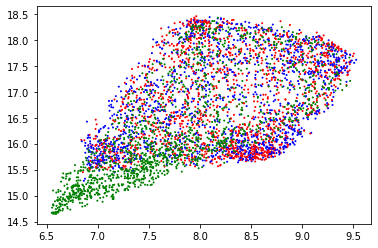

In [101]:
label                 = y_test_all
clabel                = np.empty((label.shape[0]),dtype=str)
clabel[label[:,0]==1] = 'b'
clabel[label[:,1]==1] = 'r'
clabel[label[:,2]==1] = 'g'
standard_embedding    = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test_all[:,index])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

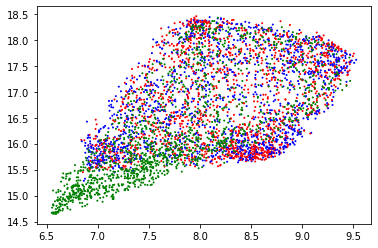

In [102]:
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test_all)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

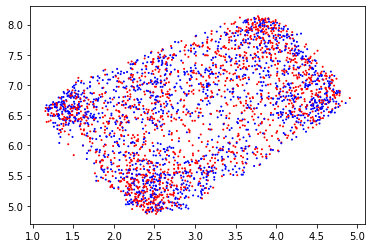

In [103]:
label = y_test
clabel = ["b" if l == 1 else "r" for l in label[:,0]]
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test[:,index])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

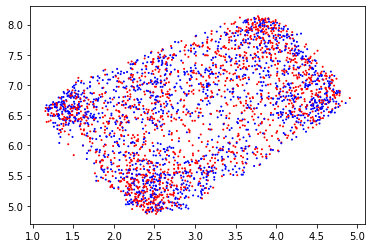

In [104]:
label = y_test
clabel = ["b" if l == 1 else "r" for l in label[:,0]]
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

In [105]:
sim  = ['TNG', 'SIMBA']; field = 'HI'
study_name = "TNG_SIMBA_HI_wph_high3_adamw"
storage    = f"sqlite:////mnt/home/yjo10/ceph/CAMELS/MIEST/information_bottleneck/database/{study_name}.db"
mist = MIST(sim=sim, field=field, batch_size=1000, 
            data_type = 'wph',
            normalization=True,
            monopole = True,
            projection=False,
            average=False,
            device=device,
            L=4, dn=2, proc_imag=np.absolute)
mist.load_optuna_models(storage=storage,study_name=study_name, which_machine="vib+cls",num_trial=291)

In [106]:
X_ast, y_ast = mist.load_data(external=True, external_sims='ASTRID')

In [107]:
clf, auc, fi, testset, trainset = do_classification(mist)
Z_test, y_test, y_pred = testset

In [108]:
print(auc)

0.751136729997443


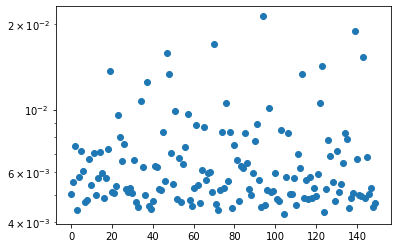

In [109]:
fi = clf.feature_importances_
plt.scatter(range(len(fi)), fi)
plt.yscale("log")
index = np.where(fi>1e-4)[0]
not_index = np.where(fi<=1e-4)[0]

In [110]:
Z_train, y_train = trainset

#### include ASTRID

In [111]:
ast_indices = np.random.randint(low=0, high=X_ast.shape[0], size=Z_test.shape[0]//2)
X_ast_test, y_ast_test = X_ast[ast_indices,:], y_ast[ast_indices,:]
Z_ast_test = mist.get_latent_variable(X_ast_test)

In [112]:
Z_test_all = np.r_[Z_test,Z_ast_test]
Z_test_all.shape
y_test_all = np.zeros((Z_test_all.shape[0], 3))
y_test_all[:Z_test.shape[0],:2] = y_test
y_test_all[Z_test.shape[0]:,2]  = 1 

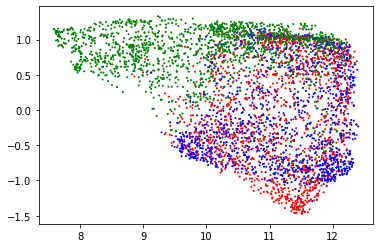

In [113]:
label                 = y_test_all
clabel                = np.empty((label.shape[0]),dtype=str)
clabel[label[:,0]==1] = 'b'
clabel[label[:,1]==1] = 'r'
clabel[label[:,2]==1] = 'g'
standard_embedding    = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test_all[:,index])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

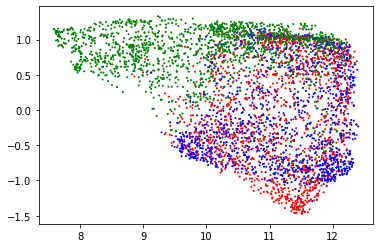

In [114]:
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test_all)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

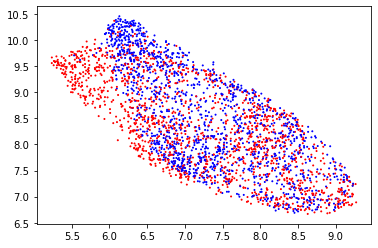

In [115]:
label = y_test
clabel = ["b" if l == 1 else "r" for l in label[:,0]]
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test[:,index])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

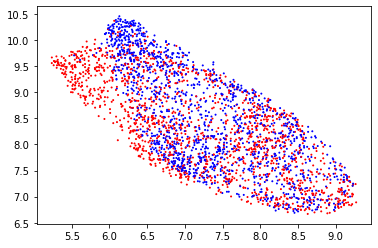

In [116]:
label = y_test
clabel = ["b" if l == 1 else "r" for l in label[:,0]]
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

### Maybe I can do estimation based on only common latent variables. I should compare Z_common+ Z_dist vs Z_common

In [252]:
reg = {}; Z_train = {}; Z_test = {}; y_pred = {}; types = ['all', 'common', 'distinct']; 

In [260]:
tng_index  = mist.test_indices[mist.test_indices<15000]
sim_index  = mist.test_indices[mist.test_indices>=15000]
X_tng_test = mist.input[tng_index]
X_sim_test = mist.input[sim_index]
y_tng_test = mist.output[tng_index,:2]
y_sim_test = mist.output[sim_index,:2]
Z_tng_test = mist.get_latent_variable(X_tng_test)
Z_sim_test = mist.get_latent_variable(X_sim_test)

In [261]:
y_test             = [y_tng_test, y_sim_test]
Z_test['all']      = [Z_tng_test, Z_sim_test]
Z_test['common']   = [Z_tng_test[:,not_index], Z_sim_test[:,not_index]]
Z_test['distinct'] = [Z_tng_test[:,index], Z_sim_test[:,index]]

In [283]:
_, y                = mist.train_loader.dataset.tensors
y_train             = y[mist.train_indices,:2].cpu().detach().numpy()
Z_train['all']      = trainset[0]
Z_train['common']   = trainset[0][:,not_index]
Z_train['distinct'] = trainset[0][:,index]
reg['all']          = RandomForestRegressor(n_estimators=500, max_depth=40, random_state=0, n_jobs=-1)
reg['common']       = RandomForestRegressor(n_estimators=500, max_depth=40, random_state=0, n_jobs=-1)
reg['distinct']     = RandomForestRegressor(n_estimators=500, max_depth=40, random_state=0, n_jobs=-1)
for t in types:
    reg[t].fit(Z_train[t], y_train)

In [284]:
for t in types:
    y_pred[t] = [reg[t].predict(Z_test[t][0]), reg[t].predict(Z_test[t][1])]

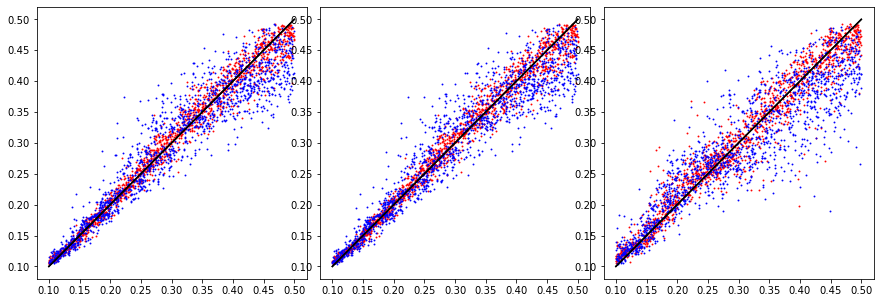

In [285]:
figsize = (15,5) 
axes    = generateAxesForMultiplePlots(shape=(3,1),figsize=figsize,wspace=0.05,hspace=0.05)
k       = 0
colors  = ['r','b']
ideal   = [0.1,0.5]
for i, t in enumerate(types):
    for j in range(2):
        axes[i,0].scatter(y_test[j][:,k], y_pred[t][j][:,k], s=0.8, c=colors[j])
        axes[i,0].plot(ideal, ideal, c='k')

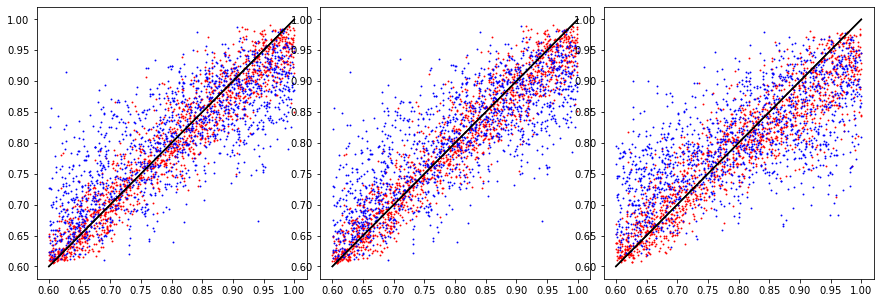

In [286]:
figsize = (15,5) 
axes    = generateAxesForMultiplePlots(shape=(3,1),figsize=figsize,wspace=0.05,hspace=0.05)
k       = 1
colors  = ['r','b']
ideal   = [0.6,1.0]
for i, t in enumerate(types):
    for j in range(2):
        axes[i,0].scatter(y_test[j][:,k], y_pred[t][j][:,k], s=0.8, c=colors[j])
        axes[i,0].plot(ideal, ideal, c='k')

In [ ]:
Z_ast_test_comm = Z_ast_test[:,not_index]
Z_ast_test_dist = Z_ast_test[:,index]
y_pred_comm = reg_comm.predict(Z_ast_test_comm)
y_pred_all = reg_all.predict(Z_ast_test)
y_pred_dist = reg_dist.predict(Z_ast_test_dist)

In [232]:
_, y_test   = mist.test_dataset.tensors
y_test      = y_test[:,:2].cpu().detach().numpy()
Z_test_comm = Z_test[:,not_index]
Z_test_dist = Z_test[:,index]
y_pred_comm = reg_comm.predict(Z_test_comm)
y_pred_all  = reg_all.predict(Z_test)
y_pred_dist = reg_dist.predict(Z_test_dist)

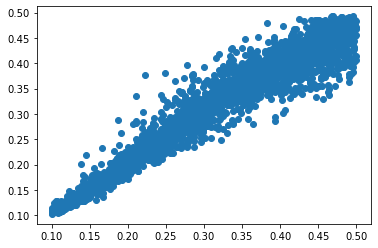

In [236]:
plt.scatter(y_test[:,0], y_pred_comm[:,0])
#plt.scatter(y_test[:,1], y_pred_comm[:,1])

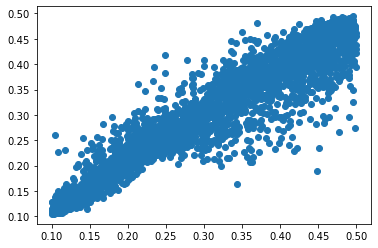

In [237]:
plt.scatter(y_test[:,0], y_pred_dist[:,0])
#plt.scatter(y_test[:,1], y_pred_dist[:,1])

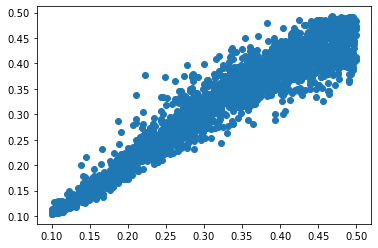

In [238]:
plt.scatter(y_test[:,0], y_pred_all[:,0])
#plt.scatter(y_test[:,1], y_pred_all[:,1])

In [229]:
Z_ast_test_comm = Z_ast_test[:,not_index]
Z_ast_test_dist = Z_ast_test[:,index]
y_pred_comm = reg_comm.predict(Z_ast_test_comm)
y_pred_all = reg_all.predict(Z_ast_test)
y_pred_dist = reg_dist.predict(Z_ast_test_dist)

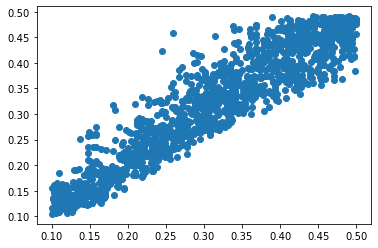

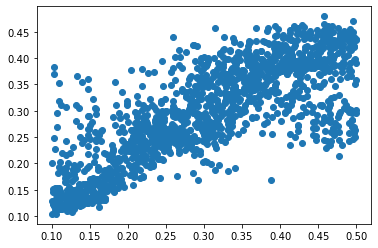

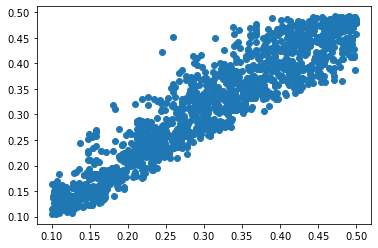

In [230]:
plt.scatter(y_ast_test[:,0], y_pred_comm[:,0])
plt.show()
plt.scatter(y_ast_test[:,0], y_pred_dist[:,0])
plt.show()
plt.scatter(y_ast_test[:,0], y_pred_all[:,0])

## Vcdm, VIB+CLS

In [4]:
sim  = ['TNG', 'SIMBA']; field = 'Vcdm'
study_name = "TNG_SIMBA_Vcdm_cnn+cls_zero_monopole_1"
storage    = f"sqlite:////mnt/home/yjo10/ceph/CAMELS/MIEST/information_bottleneck/database/{study_name}.db"
mist = MIST(sim=sim, field=field, batch_size=32, 
            data_type = 'image',
            normalization=True,
            monopole = True,
            device=device)
mist.load_optuna_models(storage=storage,study_name=study_name, which_machine="vib_cnn",num_trial=None)

num_trial=12, params={'dropout': 0.4584785645624165, 'hidden': 5, 'lr': 0.0016914472873809463, 'wd': 3.1240239713724924e-08, 'z_dim': 1587} 


In [5]:
clf, auc, fi, testset, trainset = do_classification(mist)

In [6]:
print(auc)

0.5203227312647998


In [8]:
clf, auc, fi, testset, trainset = do_classification(mist)
Z_test, y_test, y_pred = testset

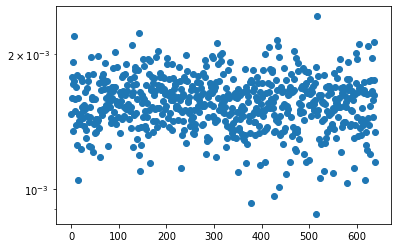

In [10]:
fi = clf.feature_importances_
plt.scatter(range(len(fi)), fi)
plt.yscale("log")
index = np.where(fi>1e-2)[0]
not_index = np.where(fi<=1e-4)[0]

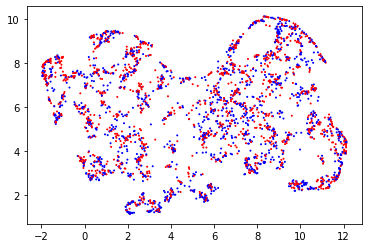

In [13]:
label = y_test
clabel = ["b" if l == 1 else "r" for l in label[:,0]]
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

## T, VIB+CLS

In [145]:
sim  = ['TNG','SIMBA']; field = 'T'
study_name = 'TNG_SIMBA_{}_cnn+cls_new'.format(field)
storage    = f"sqlite:////mnt/home/yjo10/ceph/CAMELS/MIEST/information_bottleneck/database/{study_name}.db"
mist = MIST(sim=sim, field=field, batch_size=32, 
            data_type = 'image',
            normalization=True,
            monopole = True,
            device=device)
mist.load_optuna_models(storage=storage,study_name=study_name, which_machine="vib_cnn",num_trial=None)

15000
num_trial=24, params={'dropout': 0.12796997330736995, 'hidden': 6, 'lr': 8.23944698735165e-05, 'wd': 1.7658130338176168e-05, 'z_dim': 1353} 


In [146]:
clf, auc, fi, testset, trainset = do_classification(mist)

In [147]:
Z_test, y_test, y_pred = testset

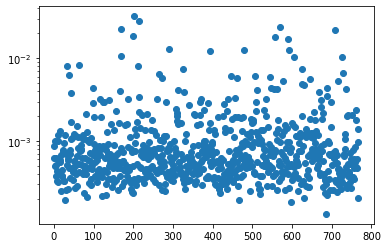

In [148]:
fi = clf.feature_importances_
plt.scatter(range(len(fi)), fi)
plt.yscale("log")
index = np.where(fi>0.01)[0]

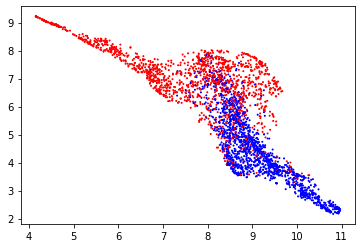

In [149]:
label = y_test
clabel = ["b" if l == 1 else "r" for l in label[:,0]]
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test[:,index])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

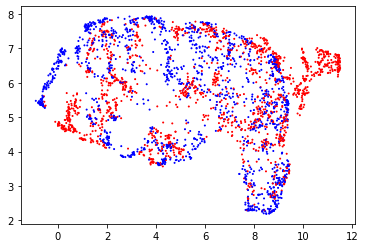

In [150]:
label = y_test
clabel = ["b" if l == 1 else "r" for l in label[:,0]]
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

## Mtot TNG+ASTRID

In [4]:
sim  = ['TNG','ASTRID']; field = 'Mtot'
study_name = 'TNG_ASTRID_{}_cnn+cls_zero'.format(field)
storage    = f"sqlite:////mnt/home/yjo10/ceph/CAMELS/MIEST/information_bottleneck/database/{study_name}.db"
mist = MIST(sim=sim, field=field, batch_size=32, 
            data_type = 'image',
            normalization=True,
            monopole = True,
            device=device)
mist.load_optuna_models(storage=storage,study_name=study_name, which_machine="vib_cnn",num_trial=None)

15000
num_trial=12, params={'dropout': 0.41826065579790944, 'hidden': 12, 'lr': 0.0003612032305727678, 'wd': 1.0927704554146291e-05, 'z_dim': 233} 


$\Omega_m$: MSE=0.000, % error=3.440%, R2 score=0.985,chi2=0.533, bias=-0.012
$\sigma_8$: MSE=0.002, % error=4.322%, R2 score=0.828,chi2=4.227, bias=0.035


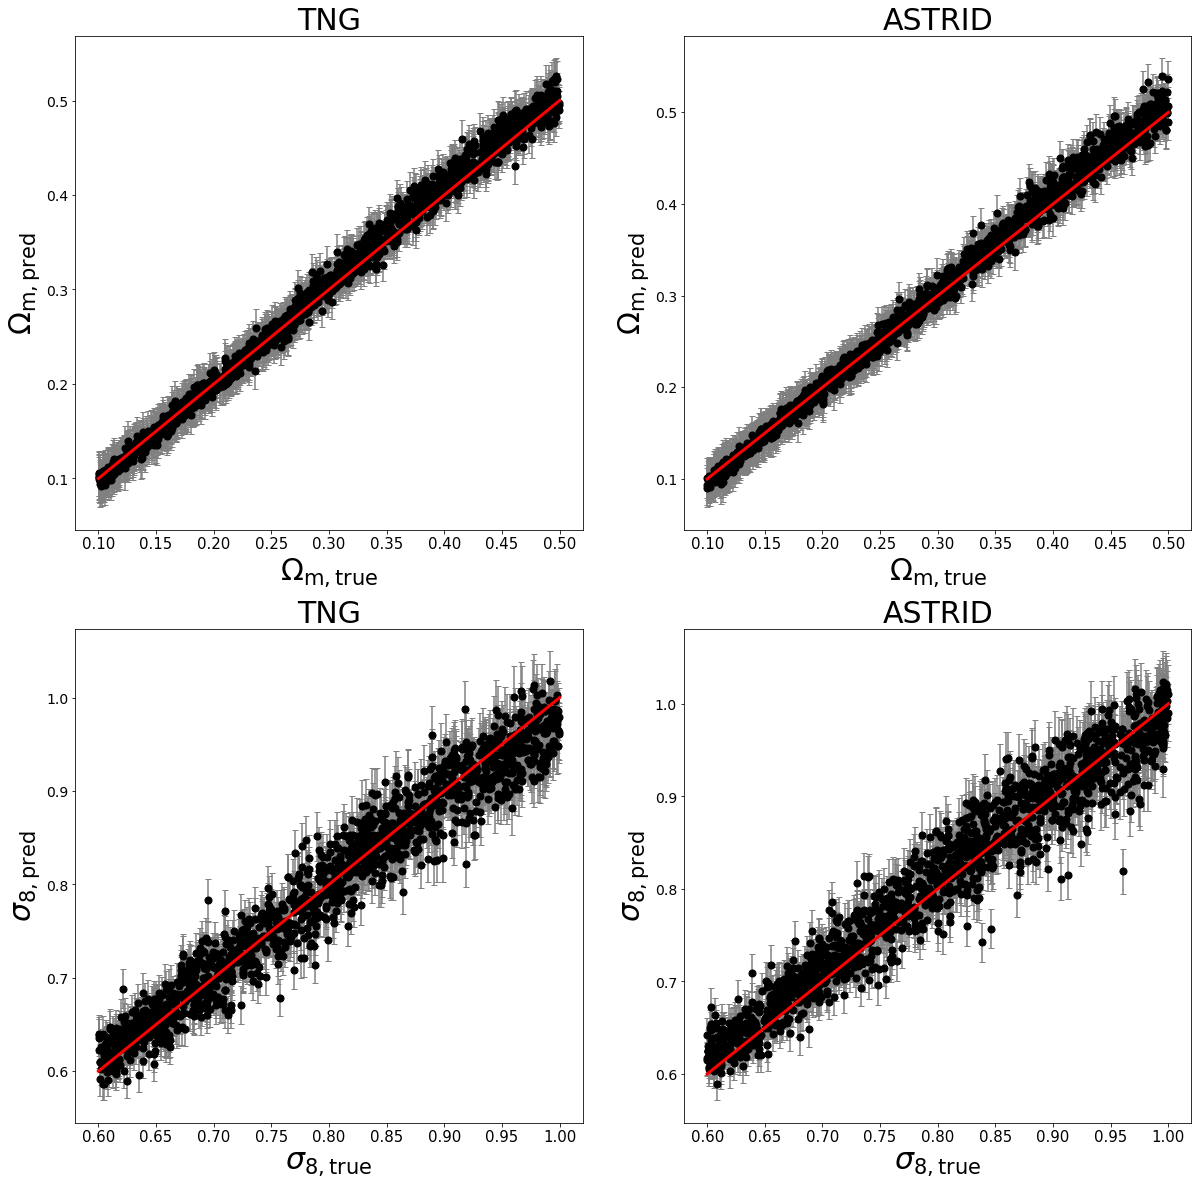

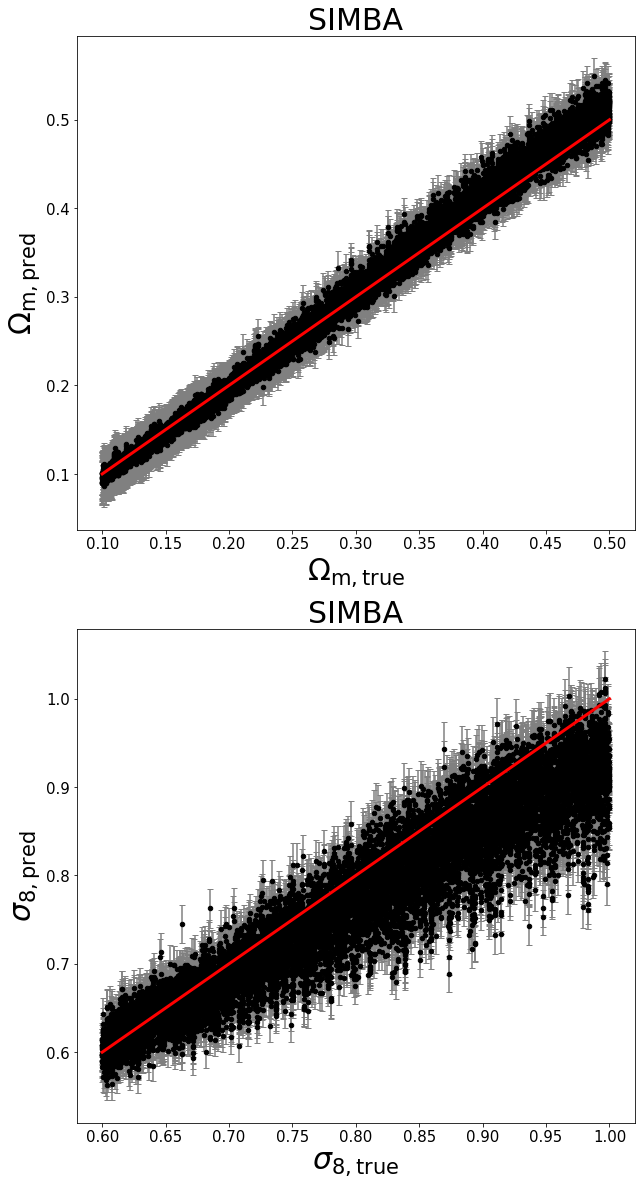

In [5]:
mist.make_plots_cnn(fname='cnn_test')
mist.test_on_cnn('SIMBA', show_score=True)

In [6]:
clf, auc, fi, testset, trainset = do_classification(mist)
Z_test, y_test, y_pred = testset
auc

0.5734611066024836

In [3]:
sim  = ['TNG','ASTRID']; field = 'Mtot'
study_name = 'TNG_ASTRID_{}_cnn+cls_high'.format(field)
storage    = f"sqlite:////mnt/home/yjo10/ceph/CAMELS/MIEST/information_bottleneck/database/{study_name}.db"
mist = MIST(sim=sim, field=field, batch_size=32, 
            data_type = 'image',
            normalization=True,
            monopole = True,
            device=device)
mist.load_optuna_models(storage=storage,study_name=study_name, which_machine="vib_cnn",num_trial=None)

15000
num_trial=16, params={'dropout': 0.14132766588193113, 'hidden': 7, 'lr': 0.0001292614790150684, 'wd': 2.2207025111554497e-06, 'z_dim': 764} 


In [4]:
clf, auc, fi, testset, trainset = do_classification(mist)
Z_test, y_test, y_pred = testset
auc

0.5527509421796312

In [5]:
sim  = ['TNG','ASTRID']; field = 'Mtot'
study_name = 'TNG_ASTRID_{}_cnn+cls_high2'.format(field)
storage    = f"sqlite:////mnt/home/yjo10/ceph/CAMELS/MIEST/information_bottleneck/database/{study_name}.db"
mist = MIST(sim=sim, field=field, batch_size=32, 
            data_type = 'image',
            normalization=True,
            monopole = True,
            device=device)
mist.load_optuna_models(storage=storage,study_name=study_name, which_machine="vib_cnn",num_trial=20)

15000
num_trial=20, params={'dropout': 0.17840288339659308, 'hidden': 6, 'lr': 0.00016110240868712756, 'wd': 0.0008930925958485776, 'z_dim': 471} 


In [6]:
clf, auc, fi, testset, trainset = do_classification(mist)
Z_test, y_test, y_pred = testset
auc

0.4840012895909996

### See if Z_[tng,simba,astrid] are distinguishable permutatively.

## Mtot

In [4]:
sim  = ['TNG','SIMBA']; field = 'Mtot'
study_name = 'TNG_SIMBA_{}_cnn+cls_multi'.format(field)
storage    = f"sqlite:////mnt/home/yjo10/ceph/CAMELS/MIEST/information_bottleneck/database/{study_name}.db"
mist = MIST(sim=sim, field=field, batch_size=32, 
            data_type = 'image',
            normalization=True,
            monopole = True,
            device=device)
mist.load_optuna_models(storage=storage,study_name=study_name, which_machine="vib_cnn",num_trial=None)

15000
num_trial=33, params={'dropout': 0.15537182776936576, 'hidden': 11, 'lr': 0.00035450334707527, 'wd': 1.435527794760265e-05, 'z_dim': 858} 


In [5]:
clf, auc, fi, testset, trainset = do_classification(mist)
Z_test, y_test, y_pred = testset

In [6]:
print(auc)

0.5691009549643695


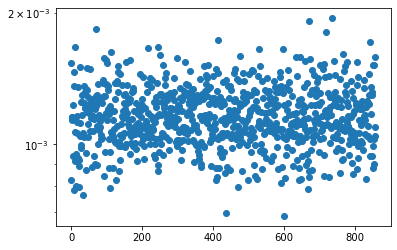

In [135]:
fi = clf.feature_importances_
plt.scatter(range(len(fi)), fi)
plt.yscale("log")
index = np.where(fi>1.5*1e-3)[0]

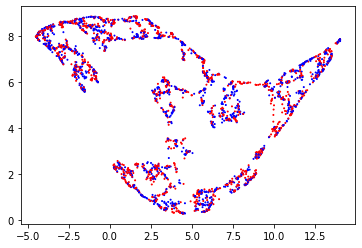

In [136]:
label = y_test
clabel = ["b" if l == 1 else "r" for l in label[:,0]]
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test[:,index])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

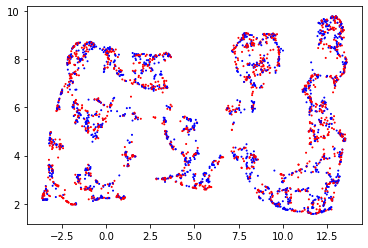

In [134]:
label = y_test
clabel = ["b" if l == 1 else "r" for l in label[:,0]]
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

## HI

In [151]:
sim  = ['TNG','SIMBA']; field = 'HI'
study_name = 'TNG_SIMBA_{}_cnn+cls'.format(field)
storage    = f"sqlite:////mnt/home/yjo10/ceph/CAMELS/MIEST/information_bottleneck/database/{study_name}.db"
mist = MIST(sim=sim, field=field, batch_size=32, 
            data_type = 'image',
            normalization=True,
            monopole = True,
            device=device)
mist.load_optuna_models(storage=storage,study_name=study_name, which_machine="vib_cnn",num_trial=None)
#mist.make_plots_cnn(fname='cnn_test')
#z = mist.get_latent_variable()
#mist.test_on_cnn('ASTRID', show_score=True)

15000
num_trial=22, params={'dropout': 0.1028707382731045, 'hidden': 10, 'lr': 0.0006533372173072661, 'wd': 7.390551155446584e-05, 'z_dim': 461} 


In [152]:
clf, auc, fi, testset, trainset = do_classification(mist)
Z_test, y_test, y_pred = testset

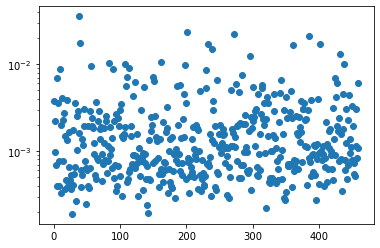

In [155]:
fi = clf.feature_importances_
plt.scatter(range(len(fi)), fi)
plt.yscale("log")
index = np.where(fi>1e-2)[0]

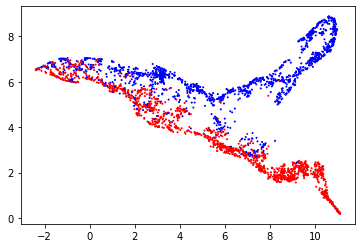

In [157]:
label = y_test
clabel = ["b" if l == 1 else "r" for l in label[:,0]]
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test[:,index])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');

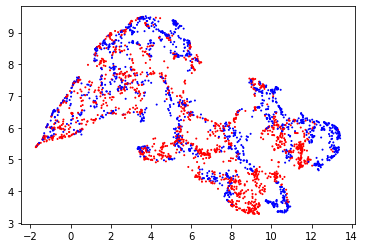

In [158]:
label = y_test
clabel = ["b" if l == 1 else "r" for l in label[:,0]]
standard_embedding = umap.UMAP(n_neighbors=40,min_dist=0.01,n_components=20,random_state=3).fit_transform(Z_test)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clabel, s=1, cmap='Spectral');